# **Note: I am using garbage collector and deleting huge lists to avoid crashing of the notebook due to insufficient RAM**

In [ ]:
import re
import os
import gc
import math
import time
import pickle
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

# **Evaluation**

**ROC Curve- Receiver Operating Characteristic**

In [ ]:
def roc_curve(true,pred):
    

    thresholds = np.array(list(range(0,100,10)))/100
    roc = []
    for threshold in thresholds:
        true_positive,false_negative,true_negative,false_positive = 0,0,0,0
        for actual,predicted  in zip(true,pred):
            # print(actual,predicted,threshold)
            if predicted > threshold:
                class_ = 1
            else:
                class_ = 0

            if actual == 1 and predicted == 1:
                true_positive +=1
            elif actual == 1 and predicted ==0:
                false_negative +=1
            elif actual == 0 and predicted == 0:
                true_negative +=1
            else:
                false_positive+=1

        print(true_negative,true_positive,false_positive,false_negative)
        try:
            true_positive_rate = true_positive/(false_negative + true_positive)
            false_positve_rate = false_positive/(false_negative + true_positive)
            precision = true_positive / (true_positive + false_positive)
            roc.append([threshold,true_positive_rate,false_positve_rate,precision])
        except Exception as e:
            print(str(e),roc)
            pass
            
        
    
    return roc

**AUC - Area Under the Curve**

In [ ]:
def auc(roc):
    auc_val= np.trapz(true_positive_rate,false_positve_rate)
    return  (round(abs(auc_val)),2)
    

In [ ]:
# model = torch.load()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# **Input data: Review Data** 

I have placed a pickle file of the review_data.csv in my github

You can even upload the csv file by browing you file system and uploading it


In [ ]:

if os.path.exists('/content/review_data.csv'):
    #if already uploaded read from here
    with open('/content/review_data.csv', 'r') as f:
        sentiment_data = pd.read_csv(f,header=0)
else:

    try:
        sentiment_data = pd.read_parquet("https://github.com/Srigowri/AssignmentDatasets/blob/master/review_parquet.gzip?raw=true")
    except:
        from google.colab import files
        import io
        #upload if not present
        print("File not present,please upload by selecting the file")
        from google.colab import files
        sentiment_file = files.upload()
        print(sentiment_file.keys())
        sentiment_data = pd.read_csv(io.BytesIO(sentiment_file['review_data.csv']))
print("Number of reviews in the csv",len(sentiment_data))
print("Fields in the CSV data",sentiment_data.columns)

Number of reviews in the csv 50000
Fields in the CSV data Index(['final_review', 'sentiment'], dtype='object')


In [ ]:
print(tabulate(sentiment_data.head(), headers="firstrow", tablefmt="grid"))

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Preprocessing the textual information**



Convert to lower case, remove any character other than alphabet and replace the +s with spaces

In [ ]:
sentiment_data["final_review"] =  sentiment_data["final_review"].apply(lambda x:x.lower())
sentiment_data["final_review"] =  sentiment_data["final_review"].apply(lambda x:re.sub(r"[^a-z]"," ",x))
sentiment_data["final_review"] =  sentiment_data["final_review"].apply(lambda x:re.sub(r" +"," ",x))

In [ ]:
def get_reviews(sentiment_data):
    """
    Input: sentiment_data- pandas a dataframe with final_review and sentiment labels
    Output: Split each review sentence to words and return the list of reviews and labels
    """
    reviews = []
    labels = []
    for index in range(len(sentiment_data)):
        review = sentiment_data["final_review"][index].split()
        reviews.append(review)
        labels.append(sentiment_data["sentiment"][index])
    return reviews,labels

reviews, labels = get_reviews(sentiment_data)

In [ ]:
del sentiment_data

The neural networks best work with numbers & not with words so we shall translate the textual data into numerical representation



# **GLOVE Embeddings**

For this task, I am using a predefined word embeddings called Global vectors.
References: https://nlp.stanford.edu/projects/glove/

[Word embedding are mappings fOr each word to a vector of features]


In [ ]:
import zipfile
import urllib.request as request


url = "https://nlp.stanford.edu/data/glove.6B.zip"


#if already uploaded read from here
if not os.path.exists('glove.6B.zip'):
    request.urlretrieve(url,"glove.6B.zip")

embed_size=50

if not os.path.exists("glove.6B.{}d.txt".format(embed_size)):
    with zipfile.ZipFile("glove.6B.zip","r") as f:
        f.extractall()

! ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


**Review Words to Numbers**

A line in a glove file is as follows

**< word >  < vector of values >**

In [ ]:
#using defaultdict will let you specify the default value of an unknown hash in this case, any unknown word
# word_to_int["dsfasdf"] will be at index 0 and the embedding at index 0 is all 0
def get_glove_embeddings(embed_size=50):
    """
    The embedding file has one line per word
    Each line has a word and a list of vectors of size embed_size

    Output: A dictionary which maps a word to an index and 
            another dictionary that will map the index to a list of vectors
            Eg:
            "cat" -> 2
            "2" -> [1.0,2.3,4.0,.....]
    """
    import numpy as np
    from collections import defaultdict

    filename = "glove.6B.{}d.txt".format(embed_size)
    print("Getting embeddings from", filename)

    with open(filename,"r") as f:
        word_to_number = defaultdict(int)
        number_to_vector =  defaultdict(lambda: np.zeros([embed_size]))
        #starting the index at 1, as 0 will be used for any unknown words in default dict
        index = 1
        #read every the glove file line by line
        for embedding_line in f:
            line = embedding_line.split()
            word = str(line[0])                      #the first word in the line is a word
            vector = np.array(line[1:],np.float32)   #the rest are values
            word_to_number[word] = index             #map word to its index
            number_to_vector[index] = vector         #map index to vectors
            index+=1
    return word_to_number,number_to_vector

word_to_number, number_to_vector = get_glove_embeddings()
print("Total number of words",len(word_to_number))

Getting embeddings from glove.6B.50d.txt
Total number of words 400000


In [ ]:
def get_review_to_num(reviews):
    """
    Input: The given data set whose sentences are split into words
    Map every word in the sentence to an index
    """
    reviews_to_num_list = []
    for review in reviews:
        review_to_num = [word_to_number[word] for word in review]
        reviews_to_num_list.append(review_to_num)
    return reviews_to_num_list

def get_review_to_vec(reviews_to_num_list):
    """
    Input: Review whose words in the sentences are mapped to index
    Map every index of the sentence to a vector of values
    """
    reviews_to_vector_list = []
    for review  in reviews_to_num_list:
        review_to_vector = [number_to_vector[num] for num in review]
        reviews_to_vector_list.append(review_to_vector)
    return reviews_to_vector_list

reviews_to_num_list = get_review_to_num(reviews)

print("Sentence to words",reviews[0])
print("Words to index",reviews_to_num_list[0])

Sentence to words ['teenager', 'martha', 'moxley', 'maggie', 'grace', 'moves', 'high', 'class', 'area', 'belle', 'greenwich', 'connecticut', 'mischief', 'night', 'eve', 'halloween', 'murdered', 'backyard', 'house', 'murder', 'remained', 'unsolved', 'twenty', 'two', 'years', 'later', 'writer', 'mark', 'fuhrman', 'christopher', 'meloni', 'former', 'la', 'detective', 'fallen', 'disgrace', 'perjury', 'j', 'simpson', 'trial', 'moved', 'idaho', 'decides', 'investigate', 'case', 'partner', 'stephen', 'weeks', 'andrew', 'mitchell', 'purpose', 'writing', 'book', 'locals', 'squirm', 'welcome', 'support', 'retired', 'detective', 'steve', 'carroll', 'robert', 'forster', 'charge', 'investigation', 'discover', 'criminal', 'net', 'power', 'money', 'cover', 'murder', 'murder', 'greenwich', 'good', 'tv', 'movie', 'true', 'story', 'murder', 'fifteen', 'years', 'old', 'girl', 'committed', 'wealthy', 'teenager', 'whose', 'mother', 'kennedy', 'powerful', 'rich', 'family', 'used', 'influence', 'cover', 'mur

Now that we have every word converted to vector
What should be the sizes of each input?

From the below plots it can be seen that the reviews have varying input sizes
The median is less than 200

I am fixing the input size to be 500 based on the below box plot

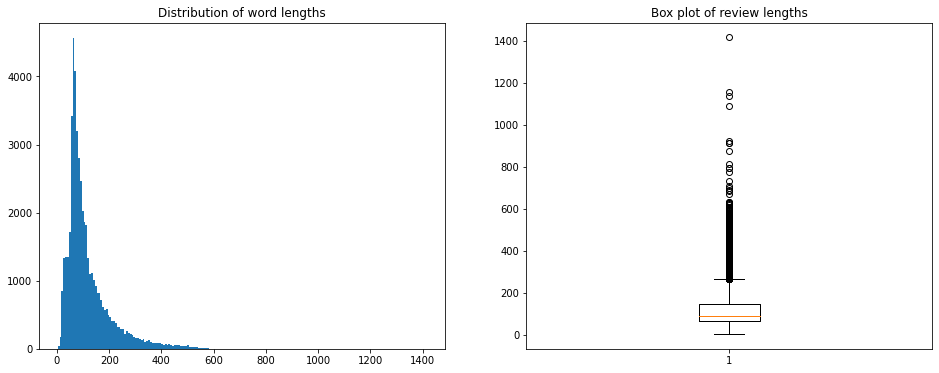

In [ ]:
len_per_review = [len(review) for review in reviews]

fig,axes =  plt.subplots(1,2,figsize=(16,6))
axes[0].hist(len_per_review,bins = 200)
axes[0].set_title("Distribution of word lengths")
axes[1].boxplot(len_per_review)
axes[1].set_title("Box plot of review lengths")
plt.show()

In [ ]:
del len_per_review
for val in [50,100,200,300]:
    os.remove("glove.6B.{}d.txt".format(val))

# **Max len of a sentence**

Based on the above box blot, I am selecting the maximum length of the sentence to be 500 words
Any thing greater will be truncated,
anything lesser will have the default index 0

In [ ]:
def trucate_or_pad(reviews_to_num_list,max_length = 500):
    for index,review in enumerate(reviews_to_num_list):
        paddings = [0]*max_length
        end = min(max_length,len(review))
        paddings[:end] = review[:end]
        reviews_to_num_list[index] = paddings
    return reviews_to_num_list

max_length = 500
reviews_to_num_list = trucate_or_pad(reviews_to_num_list)
reviews_to_vector_list = get_review_to_vec(reviews_to_num_list)

In [ ]:
# import pickle

# with open("reviews_to_vector.pkl","w") as f:
#     pickle.dump(str(reviews_to_vector_list),f)


# with open("labels.pkl","w") as f:
#     pickle.dump(str(labels),f)

In [ ]:
gc.collect()

0

# **Splitting data 80-10-10**

In [ ]:
from sklearn.model_selection  import train_test_split
trainx,testx,trainy,testy = train_test_split(reviews_to_vector_list,labels,test_size=0.1,shuffle=True)
trainx,valx,trainy,valy = train_test_split(trainx,trainy,test_size=len(testx)/len(trainx),shuffle=True)
print("Length of trainx",len(trainx))
print("Length of testx",len(testx))
print("Length of valx",len(valx))

Length of trainx 40000
Length of testx 5000
Length of valx 5000


In [ ]:
del labels
del reviews
del reviews_to_vector_list
del reviews_to_num_list
del word_to_number
del number_to_vector
gc.collect()

0

**Iterable batches**

In [ ]:
batchSize = 16

valx = torch.tensor(valx,dtype=torch.float32)
valy = torch.tensor(valy,dtype=torch.float32)
valLoader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(valx,valy),
                                           batch_size=batchSize)
del valx
del valy
gc.collect()

0

In [ ]:
batchSize = 16

trainx = torch.tensor(trainx,dtype=torch.float32)
trainy= torch.tensor(trainy,dtype=torch.float32)


#using torch's utility function to load data in batches
trainLoader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(trainx,trainy),
                                           batch_size=batchSize,                                     
                                         )

del trainx
del trainy
gc.collect()
print("Number of training examples   = ",len(trainLoader)*batchSize)

Number of training examples   =  40000


In [ ]:
! pip3 install guppy3
from guppy import hpy

h = hpy()
print(h.heap() )


     |████████████████████████████████| 614kB 7.5MB/s 


/usr/local/lib/python3.6/dist-packages/torch/distributed/distributed_c10d.py:126: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


Partition of a set of 783128 objects. Total size = 125963352 bytes.
 Index  Count   %     Size   % Cumulative  % Kind (class / dict of class)
     0 196779  25 28640698  23  28640698  23 str
     1  15354   2 22776608  18  51417306  41 list
     2 197746  25 15299840  12  66717146  53 tuple
     3  38477   5 10865411   9  77582557  62 numpy.ndarray
     4  82507  11  6568197   5  84150754  67 bytes
     5  42112   5  6094240   5  90244994  72 types.CodeType
     6  41973   5  5708328   5  95953322  76 function
     7  15850   2  5443336   4 101396658  80 dict (no owner)
     8   4651   1  4555248   4 105951906  84 type
     9   1931   0  2934032   2 108885938  86 dict of module
<1803 more rows. Type e.g. '_.more' to view.>


In [ ]:
gc.collect()

7568

In [ ]:
batchSize = 16

testx = torch.tensor(testx,dtype=torch.float32)
testy = torch.tensor(testy,dtype=torch.float32)
testLoader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(testx,testy),
                                          batch_size=batchSize)

del testx
del testy
gc.collect()

2

In [ ]:
path = "/content/"
filename = "first_run"

In [ ]:
gc.collect()

2

In [ ]:
# drive.flush_and_unmount()

Reference for the last layers of BLSTM:
https://towardsdatascience.com/understanding-bidirectional-rnn-in-pytorch-5bd25a5dd66

# **Bidirection**


I am taking the average of the forward (last sequence) and backward(first sequence) and passing it to the final classification layer which is fully connected layer

In [ ]:
class BIDIRECTIONAL_LSTM(nn.Module):
    def __init__(self,input_size,sequence_length,hidden_size,num_layers,num_classes,batch_size,batch_first=False):
        super(BIDIRECTIONAL_LSTM,self).__init__()
        self.input_size = input_size     #size of the word embedding
        self.hidden_size=hidden_size     #size of the hidden layer
        self.num_layers=num_layers       #if the lstm is stacked
        self.batch_first=batch_first     #if the batch_size is the first dimension or sequence len
        self.batch_size = batch_size
        self.sequence_length = sequence_length

        #input size will be the size of the inputs x1,...xn
        #hidden state has hidden_size
        self.bidirLSTM = torch.nn.LSTM(input_size,hidden_size,num_layers,batch_first,dropout = 0.5,bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fullyconnected = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        #initialze the weights to 0, for every element in the batch
        #num_layer,batch_size, hidden_size
        
        #x.size(1) is the batch size
        h_0 = torch.zeros(self.num_layers*2,x.size(1),self.hidden_size).to(device)
#         print(h_0.shape)
        c_0 = torch.zeros(self.num_layers*2,x.size(1),self.hidden_size).to(device)
        # seqlen,batch, hidden_size*2
        out, (h_n,c_n) = self.bidirLSTM(x,(h_0,c_0))
        #seq,batch,  hidden
        # print("befor",out.shape)
        outview = out.contiguous().view(self.sequence_length,-1, 2, self.hidden_size)
        #seq batch 2 hidden
        forward = outview[-1,:,0,:]     #-1 = last node/sequence 0 = forward 
        backward = outview[0,:,1,:]     #0 =  first node/sequence 1 = backward              
        
        #taking average of the forward and the backward passes
        out = torch.add(input=forward, other=backward,alpha=1,)
        out = torch.div(out, 2)

        # out = outview[-1,:,0,:]
        out = out.contiguous().view(-1, self.hidden_size)        
        out = self.fullyconnected(out)
        # print(out.shape)
        # out = torch.sigmoid(out)
        return out




In [ ]:
batch_size = 16
sequence_length = max_length #500
input_size = embed_size #50
hidden_size = 128
num_layers = 2
num_classes = 2

#to use gpu
model = BIDIRECTIONAL_LSTM(input_size,sequence_length, hidden_size, num_layers, num_classes,batch_size).to(device)

    
learning_rate = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
gc.collect()

2

# ***Training ***

In [ ]:
epoch,nEpochs = 0,15
log_interval = 100  #step size

dataset_size = len(trainLoader.dataset) #number of reviews in training dataset
valdata_size = len(valLoader.dataset) #number of reviews in validation dataset
best_accuracy = math.inf
trainLosses,trainAccuracy,validationAccuracy = [],[],[]
validationLoss =[]
clip =5
# fig,axes = plt.subplots(1,4,figsize=(25,6))
start = time.time()

while epoch <= nEpochs:# and not stop_training:

    model.train()
    running_corrects = 0
    running_loss = 0
    batch = 0
    for batch_num, (seq, labels) in enumerate(trainLoader):
        # seq = seq.reshape(sequence_length,batch_size ,input_size).to(device)
        seq = seq.reshape(sequence_length,-1 ,input_size).to(device)  #the batch size might not be same as batch_size for the last batch
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(seq).to(device)
        _,predictions =  torch.max(outputs, 1) #max of the final layer 
        running_corrects += (torch.sum(predictions==labels).item()) #number of right predicitions         
        
        #backpropagate
        with torch.set_grad_enabled(True):
            loss = criterion(outputs, labels.long())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

        loss_value = loss.detach().item()
        running_loss += loss_value
        # batch += len(trainLoader)
        if batch_num % log_interval == 0:  #at step size, output batch loss        
            print('Training Epoch: {0}[{1}/{2} sentences]\
            Training Loss: {3:.6f}'.format(epoch+1, batch_num * batch_size,dataset_size,loss_value))   
    trainAccuracy.append(running_corrects/len(trainLoader))
    trainLosses.append(running_loss/len(trainLoader))


    #validation
    model.eval()
    with torch.set_grad_enabled(False):  #gradient not backpack propagated
        val_losses = 0
        val_accuracy = 0
        for _, (val_batch, val_labels ) in enumerate(valLoader):                    
            # val_batch = val_batch.reshape(sequence_length,batch_size ,input_size).to(device)
            val_batch = val_batch.reshape(sequence_length,-1 ,input_size).to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_batch).to(device)
            #find the average loss and the total loss
            val_losses+=(criterion(val_outputs, val_labels.long()).item())

            _, val_predictions = torch.max(val_outputs, 1)
            val_accuracy+=(torch.sum(val_predictions==val_labels).item() )

        validationAccuracy.append(val_accuracy/len(valLoader)) 
        validationLoss.append(val_losses/len(valLoader))

    print('After Epoch: {0}\
            Training Loss: {1:.6f}\
            Training Accuracy {2:.6f}\
            Validation Loss: {3:.6f}\
            Validation Accuracy {4:.6f}'.format(epoch+1,trainLosses[-1],trainAccuracy[-1],validationLoss[-1],validationAccuracy[-1])) 
        
    
    if validationAccuracy[-1] > best_accuracy:
            best_Accuracy = validationAccuracy[-1]
            best_model_weights = copy.deepcopy(model.state_dict())            
            torch.save(best_model_weights, path+filename+".pt") 
    with open(path+filename+".pkl","wb") as f:
        pickle.dump([trainLosses,trainAccuracy,validationAccuracy],f)
                                 
    # axes[0].plot(trainLosses,label="Training loss")
    # axes[1].plot(validationLoss,label="Validation loss")
    # axes[3].plot(validationAccuracy,label="Validation accuracy")
    # axes[2].plot(trainAccuracy,label="Training accuracy")
    
    epoch = epoch + 1
    
end = time.time()
# plt.show()


Training Epoch: 1[0/40000 sentences]            Training Loss: 0.691497
Training Epoch: 1[1600/40000 sentences]            Training Loss: 0.685882
Training Epoch: 1[3200/40000 sentences]            Training Loss: 0.695251
Training Epoch: 1[4800/40000 sentences]            Training Loss: 0.701367
Training Epoch: 1[6400/40000 sentences]            Training Loss: 0.717480
Training Epoch: 1[8000/40000 sentences]            Training Loss: 0.691240
Training Epoch: 1[9600/40000 sentences]            Training Loss: 0.692179
Training Epoch: 1[11200/40000 sentences]            Training Loss: 0.685556
Training Epoch: 1[12800/40000 sentences]            Training Loss: 0.692602
Training Epoch: 1[14400/40000 sentences]            Training Loss: 0.697843
Training Epoch: 1[16000/40000 sentences]            Training Loss: 0.676955
Training Epoch: 1[17600/40000 sentences]            Training Loss: 0.699188
Training Epoch: 1[19200/40000 sentences]            Training Loss: 0.693417
Training Epoch: 1[2080

In [ ]:
! ls

first_run.pkl  glove.6B.zip  sample_data


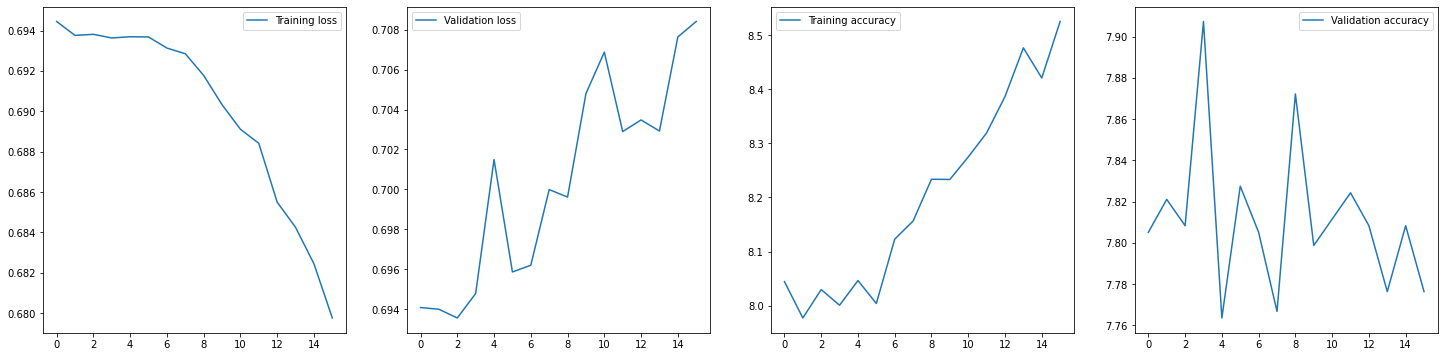

In [ ]:
fig,axes = plt.subplots(1,4,figsize=(25,6))
axes[0].plot(list(range(0,len(trainLosses),1)),trainLosses,label="Training loss")
axes[0].legend()
axes[1].plot(validationLoss,label="Validation loss")
axes[1].legend()
axes[2].plot(trainAccuracy,label="Training accuracy")
axes[2].legend()
axes[3].plot(validationAccuracy,label="Validation accuracy")
axes[3].legend()
plt.show()

In [ ]:
print("Time taken in minutes",(end-start)/60)

Time taken in minutes 48.648439383506776


# **Testing**

In [ ]:
model.eval()

softmax = torch.nn.Softmax()
true = []
pred = []
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    for _, (test_batch, test_labels ) in enumerate(testLoader):                    
        # test_batch = test_batch.reshape(sequence_length,batch_size ,input_size).to(device)
    
        test_batch = test_batch.reshape(sequence_length,-1 ,input_size).to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_batch).to(device)

        
        probabilities = softmax(test_outputs) 
        # print(probabilities)
        test_loss+= (criterion(test_outputs, test_labels.long()).item())
        test_predictions, test_predicted_class = torch.max(probabilities, 1)
       
        test_accuracy+=(torch.sum(test_predicted_class==test_labels).item())
        
        true.extend(test_labels)
        pred.extend(test_predictions)



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
print("Test loss is",test_loss/len(testLoader.dataset))
print(" Accuracy is",test_accuracy/len(testLoader.dataset)*100)

Test loss is 0.04413525539636612
 Accuracy is 50.339999999999996


In [ ]:
roc = roc_curve(true,pred)
true_positive_rate = np.array(roc)[:,1]
false_positve_rate = np.array(roc)[:,2]

print(auc(true_positive_rate,false_positve_rate))
precision = np.array(roc)[:,3]

fig,axes = plt.subplots(1,2)

axes[0].scatter(true_positive_rate,false_positve_rate)
axes[1].scatter(true_positive_rate,precision)
plt.show()

In [ ]:
class BLSTM_ATTENTION(nn.Module):
    def __init__(self,input_size,sequence_length,hidden_size,num_layers,num_classes,batch_size,batch_first=False):
        super(BLSTM_ATTENTION,self).__init__()
        self.input_size = input_size
        self.hidden_size=hidden_size     #size of the hidden layer
        self.num_layers=num_layers       #if the lstm is stacked
        self.batch_first=batch_first 
        self.batch_size = batch_size
        self.sequence_length = sequence_length

        #input size will be the size of the inputs x1,...xn
        #hidden state has hidden_size
        self.bidirLSTM = nn.LSTM(input_size,hidden_size,num_layers,batch_first,dropout = 0.5,bidirectional=True)
        
        self.attention = nn.Sequential(
                                nn.Linear(self.hidden_size,32),
                                nn.ReLU(),
                                nn.Linear(32,1)
                                )
             
        self.fullyconnected = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        #initialze the weights to 0, for every element in the batch
        #num_layer,batch_size, hidden_size
        
        #x.size(1) is the batch size
        h_0 = torch.zeros(self.num_layers*2,x.size(1),self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers*2,x.size(1),self.hidden_size).to(device)
        # seqlen,batch, hidden_size*2
        out, (h_n,c_n) = self.bidirLSTM(x,(h_0,c_0))
        #seq,batch,  hidden
        out = out[:, :, :self.hidden_size] + out[:, :, self.hidden_size:]
        
#         print("after joining forward and backward",out.shape)
        
        batch = out.size(1)

        #for attention make the input to have the output size as the hidden_size
        #the attention will return value for the entire batch of sequence
        attention_out = self.attention(out.view(-1, self.hidden_size)) # (seq, batch, hidden) -> (seq* batch, 1)
        #take softmax of the attention
        attention_out = nn.functional.softmax(attention_out.view(batch, -1), dim=1).unsqueeze(2) # (seq* batch, 1) -> (seq, batch, 1)

        #making the dimension to be batch sequence 1, multiply the out and the attention layer softmax output probabilities
        matrix_mul = (out.permute(1,0,2)* attention_out).sum(dim=1)    

        #pass throught the fully connected layer
        out = self.fullyconnected(matrix_mul) #b*2
        
        return out      


# embed_size = 50
sequence_length = max_length #500
input_size = embed_size #50
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 2
batch_size = 32
try:
    attention_model = BLSTM_ATTENTION(input_size,sequence_length, hidden_size, num_layers, num_classes,batch_size).to(device)
except:
    attention_model = BLSTM_ATTENTION(input_size,sequence_length, hidden_size, num_layers, num_classes,batch_size)

    
learning_rate = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=learning_rate)

# **Training**

In [ ]:
epoch,nEpochs = 0,15
log_interval = 100  #step size

dataset_size = len(trainLoader.dataset) #number of reviews in training dataset
valdata_size = len(valLoader.dataset) #number of reviews in validation dataset
best_accuracy = math.inf
trainLosses,trainAccuracy,validationAccuracy = [],[],[]
validationLoss =[]
clip =5
# fig,axes = plt.subplots(1,4,figsize=(25,6))
start = time.time()

while epoch <= nEpochs:# and not stop_training:

    attention_model.train()
    running_corrects = 0
    running_loss = 0
    batch = 0
    for batch_num, (seq, labels) in enumerate(trainLoader):
        # seq = seq.reshape(sequence_length,batch_size ,input_size).to(device)
        seq = seq.reshape(sequence_length,-1 ,input_size).to(device)  #the batch size might not be same as batch_size for the last batch
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = attention_model(seq).to(device)
        _,predictions =  torch.max(outputs, 1) #max of the final layer 
        running_corrects += (torch.sum(predictions==labels).item()) #number of right predicitions         
        
        #backpropagate
        with torch.set_grad_enabled(True):
            loss = criterion(outputs, labels.long())
            loss.backward()
            nn.utils.clip_grad_norm_(attention_model.parameters(), clip)
            optimizer.step()

        loss_value = loss.detach().item()
        running_loss += loss_value
        # batch += len(trainLoader)
        if batch_num % log_interval == 0:  #at step size, output batch loss        
            print('Training Epoch: {0}[{1}/{2} sentences]\
            Training Loss: {3:.6f}'.format(epoch+1, batch_num * batch_size,dataset_size,loss_value))   
    trainAccuracy.append(running_corrects/len(trainLoader))
    trainLosses.append(running_loss/len(trainLoader))


    #validation
    attention_model.eval()
    with torch.set_grad_enabled(False):  #gradient not backpack propagated
        val_losses = 0
        val_accuracy = 0
        for _, (val_batch, val_labels ) in enumerate(valLoader):                    
            # val_batch = val_batch.reshape(sequence_length,batch_size ,input_size).to(device)
            val_batch = val_batch.reshape(sequence_length,-1 ,input_size).to(device)
            val_labels = val_labels.to(device)
            val_outputs = attention_model(val_batch).to(device)
            #find the average loss and the total loss
            val_losses+=(criterion(val_outputs, val_labels.long()).item())

            _, val_predictions = torch.max(val_outputs, 1)
            val_accuracy+=(torch.sum(val_predictions==val_labels).item() )

        validationAccuracy.append(val_accuracy/len(valLoader)) 
        validationLoss.append(val_losses/len(valLoader))

    print('After Epoch: {0}\
            Training Loss: {1:.6f}\
            Training Accuracy {2:.6f}\
            Validation Loss: {3:.6f}\
            Validation Accuracy {4:.6f}'.format(epoch+1,trainLosses[-1],trainAccuracy[-1],validationLoss[-1],validationAccuracy[-1])) 
        
    
    if validationAccuracy[-1] > best_accuracy:
            best_Accuracy = validationAccuracy[-1]
            best_model_weights = copy.deepcopy(attention_model.state_dict())            
            torch.save(best_model_weights, path+filename+".pt") 
    with open(path+filename+".pkl","wb") as f:
        pickle.dump([trainLosses,trainAccuracy,validationAccuracy],f)
                                 
    # axes[0].plot(trainLosses,label="Training loss")
    # axes[1].plot(validationLoss,label="Validation loss")
    # axes[3].plot(validationAccuracy,label="Validation accuracy")
    # axes[2].plot(trainAccuracy,label="Training accuracy")
    
    epoch = epoch + 1
    
end = time.time()
# plt.show()


In [ ]:
fig,axes = plt.subplots(1,4,figsize=(25,6))
axes[0].plot(list(range(0,len(trainLosses),1)),trainLosses,label="Training loss")
axes[0].legend()
axes[1].plot(validationLoss,label="Validation loss")
axes[1].legend()
axes[2].plot(trainAccuracy,label="Training accuracy")
axes[2].legend()
axes[3].plot(validationAccuracy,label="Validation accuracy")
axes[3].legend()
plt.show()

# **Testing**

In [ ]:
attention_model.eval()

softmax = torch.nn.Softmax()
true = []
pred = []
with torch.no_grad():
    test_loss = 0
    test_accuracy = 0
    for _, (test_batch, test_labels ) in enumerate(testLoader):                    
        # test_batch = test_batch.reshape(sequence_length,batch_size ,input_size).to(device)
    
        test_batch = test_batch.reshape(sequence_length,-1 ,input_size).to(device)
        test_labels = test_labels.to(device)
        test_outputs = attention_model(test_batch).to(device)

        
        probabilities = softmax(test_outputs) 
        # print(probabilities)
        test_loss+= (criterion(test_outputs, test_labels.long()).item())
        test_predictions, test_predicted_class = torch.max(probabilities, 1)
       
        test_accuracy+=(torch.sum(test_predicted_class==test_labels).item())
        
        true.extend(test_labels)
        pred.extend(test_predictions)


In [ ]:
print("Test loss is",test_loss/len(testLoader.dataset))
print(" Accuracy is",test_accuracy/len(testLoader.dataset)*100)